# EG01-EG29Transition Scenario
The following jupyter notebook demonstrates the usage of CYCLUS to run
an EG01 to EG29 transition scenario. 

* This is a simplified version, where isotopes are separated into 4 groups (U, TRU, MA, FP), represented by U238, Pu239, Am241, and Cs137


### Import Necessary Module and Set Path 
Necessary modules for analysis are imported

In [5]:
import sqlite3 as lite
import os
import sys
import collections
from pyne import nucname
sys.path.insert(0, '../scripts/')
jupyter_directory = os.getcwd()

### The analysis.py file is a simple sqlite query and plotting script to analyze and visualize cyclus SQL output files. The script can be found in [https://github.com/arfc/transition-scenarios](https://github.com/arfc/transition-scenarios)

In [6]:
import analysis as an

## Run Cyclus Input file

In [3]:
# Removes previous cyclus output file, just in case.
! rm cyclus.sqlite

# runs xml input file.
! cyclus eg01-eg29-complex.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

## Wait for the Complete message..

### The output file should be named 
         
          cyclus.sqlite

### The analysis.py works mostly like such:
    1. function returns a dictionary of timeseries (massflow, installed power, etc)
    2. plotting function (stacked_bar or line_plot) creates plots out of the dictionary
    3. png file is saved in the directory of the notebook file.

In [8]:
# define filename to create sqlite cursor for analysis
filename = 'fromsimple.sqlite'

# get sqlite cursor using a function in analysis.py
cur = an.get_cursor(filename)

# get simulation time info
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# prints net capacity and number of reactor timeseries
an.plot_power(cur)


# prints maximum required sfr fuel throughput per timestep
sfr_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON resources.resourceid = '
                       'transactions.resourceid WHERE commodity = "sfr_fuel"'
                       ' GROUP BY time').fetchall()
print(max(an.get_timeseries(sfr_fuel, duration, True)))

# prints maximum required mox fuel throughput per timestep
mox = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON resources.resourceid = '
                       'transactions.resourceid WHERE commodity = "mox"'
                      ' GROUP BY time').fetchall()
print(max(an.get_timeseries(mox, duration, True)))

# line plot of fuel throughput (non-cumulative)
fuel_stuff ={}
fuel_stuff['sfr_fuel'] = an.get_timeseries(sfr_fuel, duration, True)
fuel_stuff['mox'] = an.get_timeseries(mox, duration, True)
an.multi_line_plot(fuel_stuff, timestep, 'Years', 'Mass[MTHM]', 'Fuel', 'Fuel', init_year)


# get fuel mass timeseries
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox', 'sfr_fuel'])
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

# prints ratio between SFRs and MOX LWRs.
power_dict = an.get_power_dict(cur)
ratio = {}
ratio['fr_to_lwr_ratio'] =[x/y for x, y in zip(power_dict['fr_inst'], power_dict['mox_lwr_inst'])]
an.stacked_bar_chart(ratio, timestep, 'Year', 'FR capacity / MOX LWR capacity',
                     'Ratio vs Time', 'ratio', init_year)


# get tailings mass timeseries
agent_ids = an.get_agent_ids(cur, 'enrichment')
tailings = an.facility_commodity_flux(cur, agent_ids,
                                      ['tailings'], True)
an.stacked_bar_chart(tailings, timestep,
                  'Year', 'Mass [MTHM]',
                  'Tailings vs Time',
                  'tailings', init_year)


# get tailings mass timeseries
agent_ids = an.get_agent_ids(cur, 'enrichment')
tailings = an.facility_commodity_flux(cur, agent_ids,
                                      ['tailings'], True)
an.stacked_bar_chart(tailings, timestep,
                  'Year', 'Mass [MTHM]',
                  'Tailings vs Time',
                  'tailings', init_year)

# natural uranium demand
nat_u = collections.OrderedDict()
nat_u['nat_u'] = an.nat_u_timeseries(cur)
an.stacked_bar_chart(nat_u, timestep,
                     'Years', 'Natural Uranium Mass',
                     'Natural Uranium Demand vs Time',
                     'nat_u', init_year)

# uranium utilization
dictionary = {}
dictionary['uranium_utilization'] = an.u_util_calc(cur)
an.stacked_bar_chart(dictionary, timestep,
                     'Years', 'U Utilization Factor',
                     'U Utilization vs Time',
                     'u_util', init_year)

# get reprocessed material flow
agent_ids = an.get_agent_ids(cur, 'separations')
combined = an.facility_commodity_flux(cur, agent_ids, ['mox_Pu', 'uox_Pu', 'sfr_Pu'], True)
uox_Pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu'], True)
mox_Pu = an.facility_commodity_flux(cur, agent_ids, ['mox_Pu'], True)
sfr_Pu = an.facility_commodity_flux(cur, agent_ids, ['sfr_Pu'], True)
an.stacked_bar_chart(combined, timestep, 'Years', 'Mass[MTHM]',
                  'Total reprocessed outflux vs Time', 'combined',
                  init_year)
an.stacked_bar_chart(uox_Pu, timestep, 'Years', 'Mass[MTHM]',
                  'reprocessed from spent UOX vs Time', 'from_spent_uox',
                  init_year)
an.stacked_bar_chart(mox_Pu, timestep, 'Years', 'Mass[MTHM]',
                  'reprocessed from spent MOX vs Time', 'from_spent_mox',
                  init_year)
an.stacked_bar_chart(sfr_Pu, timestep, 'Years', 'Mass[MTHM]',
                  'reprocessed from spent SFR Fuel vs Time', 'from_spent_sfr',
                  init_year)

print('Finished!')

sink_source_facilities has no values
sink_source_facilities has no values
1455.948
132.52


/home/dkadkf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


The Average Fuel Utilization Factor is: 
0.108992942673
Finished!


# The Benefits of using a jupyter notebook is that one can run sqlite queries if a question rises.

In [34]:
# Like such:

# Number of Reactors Deployed
cur = an.get_cursor(filename)

# Number of LWRs deployed
lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "lwr"').fetchone()
print('The Number of LWRs Deployed:')
print(lwr[0])

# Number of MOX LWRs deployed
mox_lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "mox_lwr"').fetchone()
print('The Number of MOX LWRs Deployed:')
print(mox_lwr[0])

# Number of SFRs deployed
sfr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "fr"').fetchone()
print('The Number of FRs Deployed:')
print(sfr[0])

The Number of LWRs Deployed:
460
The Number of MOX LWRs Deployed:
264
The Number of FRs Deployed:
1036


In [35]:
# Fresh and Spent Fuel Composition
cur = an.get_cursor(filename)

sfr_fuel_qualid = cur.execute('SELECT qualid FROM transactions '
                              'INNER JOIN resources ON '
                              'resources.resourceid = transactions.resourceid '
                              'WHERE commodity = "sfr_fuel"').fetchone()
fresh_sfr_mox_comp = cur.execute('SELECT nucid, massfrac FROM compositions '
                                 'WHERE qualid = ' + str(sfr_fuel_qualid[0])).fetchall()
print('Composition for fresh sfr fuel: ')
for isotope in fresh_sfr_mox_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

print('\n \n')

sfr_waste_comp = cur.execute('SELECT nucid, massfrac FROM recipes '
                             'LEFT OUTER JOIN compositions '
                             'ON recipes.qualid = compositions.qualid '
                             'WHERE recipe = "sfr_waste_recipe"').fetchall()
print('Composition for sfr spent fuel: ')
for isotope in sfr_waste_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')
    


mox_fuel_qualid = cur.execute('SELECT qualid FROM transactions '
                              'INNER JOIN resources ON '
                              'resources.resourceid = transactions.resourceid '
                              'WHERE commodity = "mox"').fetchone()
fresh_mox_comp = cur.execute('SELECT nucid, massfrac FROM compositions '
                             'WHERE qualid = ' + str(sfr_fuel_qualid[0])).fetchall()
print('Composition for fresh mox fuel: ')
for isotope in fresh_mox_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')


mox_waste_comp = cur.execute('SELECT nucid, massfrac FROM recipes '
                             'LEFT OUTER JOIN compositions '
                             'ON recipes.qualid = compositions.qualid '
                             'WHERE recipe = "mox_waste_recipe"').fetchall()
print('Composition for mox spent fuel: ')
for isotope in mox_waste_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

Composition for fresh sfr fuel: 
U232: 8.76512053418823e-08 %
U233: 1.9405113376159056e-07 %
U234: 0.015066576049108967 %
U235: 0.7029770310400039 %
U236: 0.500115523039744 %
U238: 91.68184058816881 %
Pu238: 0.1741333731324616 %
Pu239: 3.6236471706254596 %
Pu240: 1.735957579164036 %
Pu241: 1.0501766896537017 %
Pu242: 0.5160680727703303 %
Pu244: 1.711465401090272e-05 %

 

Composition for sfr spent fuel: 
Cs137: 4.66 %
U238: 86.193 %
Pu239: 9.023 %
Am241: 0.124 %
Composition for fresh mox fuel: 
U232: 8.76512053418823e-08 %
U233: 1.9405113376159056e-07 %
U234: 0.015066576049108967 %
U235: 0.7029770310400039 %
U236: 0.500115523039744 %
U238: 91.68184058816881 %
Pu238: 0.1741333731324616 %
Pu239: 3.6236471706254596 %
Pu240: 1.735957579164036 %
Pu241: 1.0501766896537017 %
Pu242: 0.5160680727703303 %
Pu244: 1.711465401090272e-05 %
Composition for mox spent fuel: 
Cs137: 4.03 %
U238: 88.73 %
Pu239: 6.370000000000001 %
Am241: 0.8699999999999999 %


## Simulation Results
This cell outputs a file that contains all the metrics for this transition scenario.

In [36]:
outstring = ''
outstring += 'Initial Year:' + str(init_year) + '\n'
outstring += 'Initial Month:' + str(init_month) + '\n'
outstring += 'Duration in Months:' + str(duration) + '\n'
outstring += 'End Year:' + str(int(init_year + duration/12)) + '\n'

outstring += '\n'

outstring += 'Total Fuel Used: [MTHM]' + '\n'
first = True
for key in fuel_dict:
    outstring += '\t' + key + ': ' + str(max(fuel_dict[key])) + '\n'
    if first:
        total = fuel_dict[key]
        first = False
    else:
        total = [x + y for x, y in zip(total, fuel_dict[key])]
outstring += '\t' + key + ': ' + str(max(total)) + '\n'

outstring += '\n'

outstring += 'Total Natural Uranium [MTHM]' + '\n'
outstring += '\t' + str(max(nat_u['nat_u'])) + '\n'

outstring += 'Total Tailings [MTHM]' + '\n'
outstring += '\t' + str(max(tailings['tailings'])) + '\n'

outstring += '\n'

outstring += 'Average Fuel Utilization Factor (Fuel/NatU):' + '\n'
outstring += '\t' + str(sum(dictionary['uranium_utilization']) / len(dictionary['uranium_utilization'])) + '\n'

outstring += '\n'

outstring += 'Plutonium reprocessed: [MTHM]' + '\n'
first = True
for key in combined:
    outstring += '\t' + key + ': ' + str(max(combined[key])) + '\n'
    if first:
        total = combined[key]
        first = False
    else:
        total = [x + y for x, y in zip(total, combined[key])]
outstring += '\t Total: ' + str(max(total)) + '\n'

outstring += '\n' 

outstring += 'Reactors Deployed:' + '\n'
outstring += '\t LWR: ' + str(lwr[0]) + '\n'
outstring += '\t FR: ' + str(sfr[0]) + '\n'
outstring += '\t MOX_LWR: ' + str(mox_lwr[0]) + '\n'

outstring += '\n'

outstring += 'Compositions' + '\n'
outstring += '\t Composition for fresh sfr fuel: ' + '\n'
for isotope in fresh_sfr_mox_comp:
    outstring += '\t\t ' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'
    
outstring += '\t Composition for fresh sfr spent fuel: ' + '\n'
for isotope in sfr_waste_comp:
    outstring += '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'

outstring += 'Composition for fresh mox fuel: '
for isotope in fresh_mox_comp:
    outstring += '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' +'\n'
    
outstring += 'Composition for mox spent fuel: '
for isotope in mox_waste_comp:
    outstring +=  '\t\t' + nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %' + '\n'
    
print(outstring)
if 'simulation_results':
    with open('simulation_results', 'w') as output:
        output.write(outstring)

Initial Year:1959
Initial Month:1
Duration in Months:3024
End Year:2211

Total Fuel Used: [MTHM]
	uox: 733683.22
	mox: 200602.15
	sfr_fuel: 217178.91
	sfr_fuel: 1151464.28

Total Natural Uranium [MTHM]
	6548699.00834
Total Tailings [MTHM]
	5815015.78834

Average Fuel Utilization Factor (Fuel/NatU):
	0.11892439876

Plutonium reprocessed: [MTHM]
	mox_Pu: 10044.278175
	uox_Pu: 8495.19920106
	sfr_Pu: 17549.0680428
	 Total: 36088.5454188

Reactors Deployed:
	 LWR: 460
	 FR: 1036
	 MOX_LWR: 264

Compositions
	 Composition for fresh sfr fuel: 
		 U232: 8.76512053418823e-08 %
		 U233: 1.9405113376159056e-07 %
		 U234: 0.015066576049108967 %
		 U235: 0.7029770310400039 %
		 U236: 0.500115523039744 %
		 U238: 91.68184058816881 %
		 Pu238: 0.1741333731324616 %
		 Pu239: 3.6236471706254596 %
		 Pu240: 1.735957579164036 %
		 Pu241: 1.0501766896537017 %
		 Pu242: 0.5160680727703303 %
		 Pu244: 1.711465401090272e-05 %
	 Composition for fresh sfr spent fuel: 
		Cs137: 4.66 %
		U238: 86.193 %
		Pu239: 

### Plots
Plots can be viewed inside the notebook, but also on your local directory.

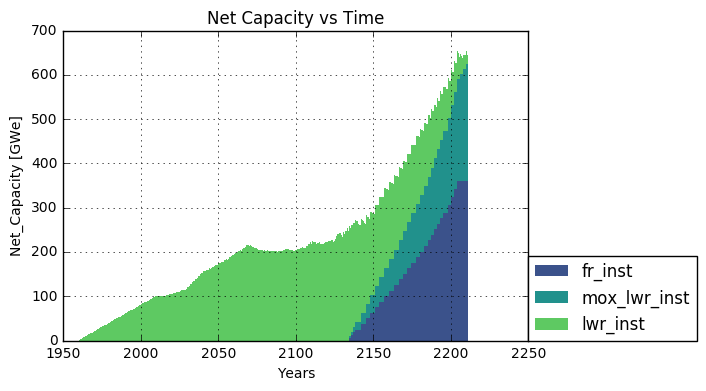

In [37]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')


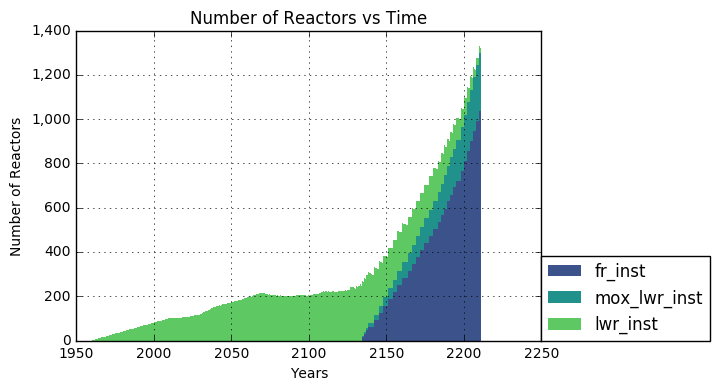

In [38]:

# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')


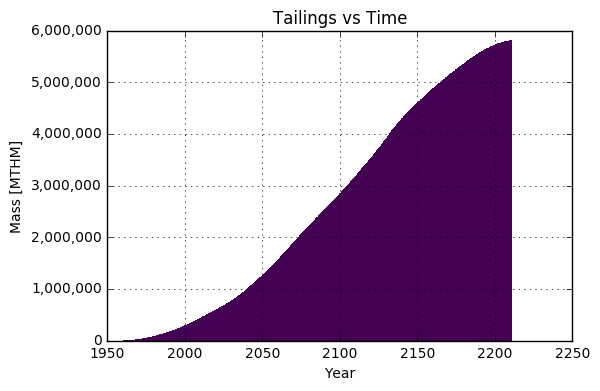

In [39]:

# Display Tailings vs Time
from IPython.display import Image
Image(filename='tailings.png')


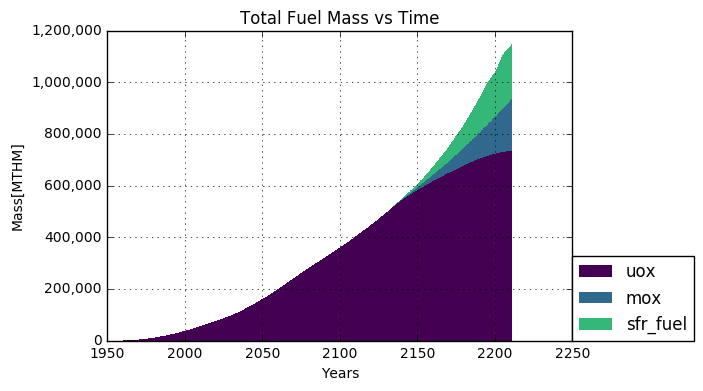

In [40]:

# Display Total Fuel vs Time
from IPython.display import Image
Image(filename='total_fuel.png')


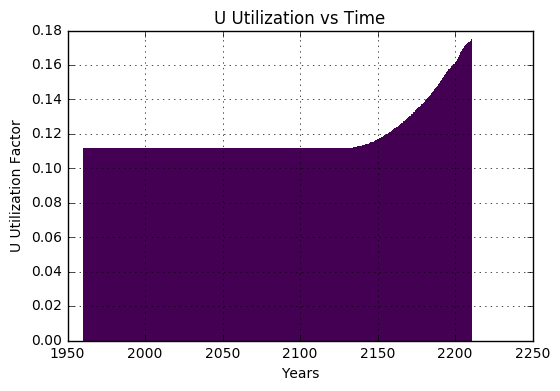

In [41]:

# Display Uranium Utilization vs Time
from IPython.display import Image
Image(filename='u_util.png')


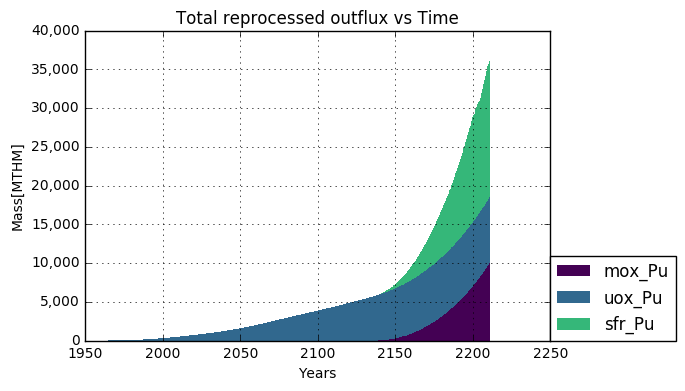

In [42]:

# Display Separated Pu Flow
from IPython.display import Image
Image(filename='combined.png')


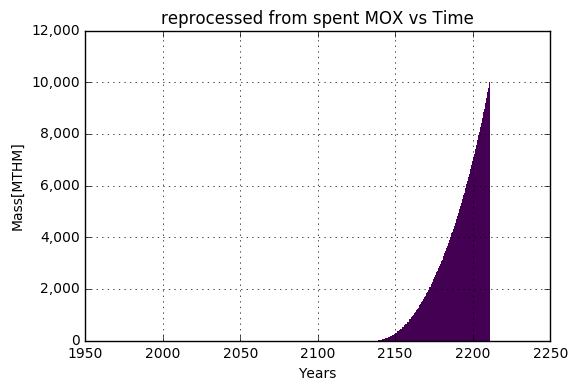

In [43]:

from IPython.display import Image
Image(filename='from_spent_mox.png')


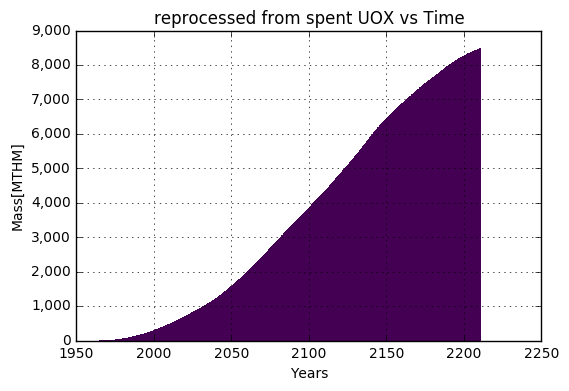

In [44]:

from IPython.display import Image
Image(filename='from_spent_uox.png')

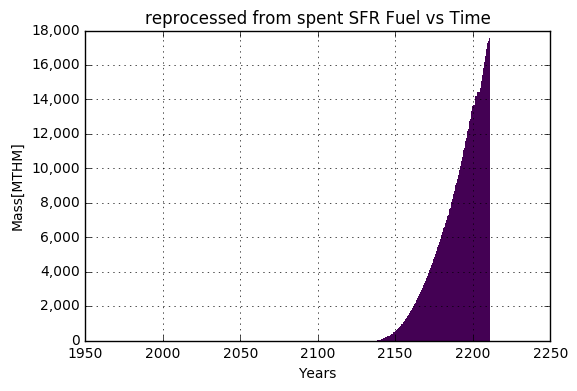

In [45]:

from IPython.display import Image
Image(filename='from_spent_sfr.png')

## CYCLUS will not operate a reactor if the necessary fuels aren't supplied.
## In this scenario, the transition is made without the adequate Pu inventory.

In [25]:
! rm lack.sqlite
! cyclus -o lack.sqlite eg01-eg29-lack.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [46]:
# Change names of power and number plots from previous simulation
# to avoid overwritting
! mv power_plot.png prev_power_plot.png
! mv num_plot.png prev_num_plot.png

In [47]:
filename = 'lack.sqlite'

# Wait for the complete message to move on

cur = an.get_cursor(filename)

# get simulation time info
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# plot installed power and number of reactors
an.plot_power(cur)
print('Finished!')

sink_source_facilities has no values
sink_source_facilities has no values
Finished!



## Note that the power does not go up to 700 GWe like the previous simulation

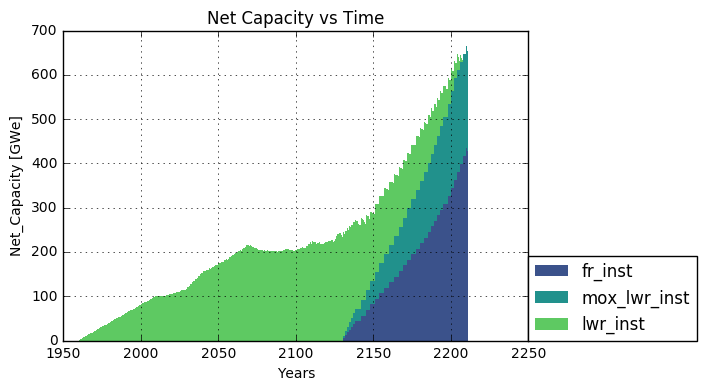

In [48]:
# Note this plot is quite different from the previous plot:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')


In [49]:
# Number of Reactors Deployed
cur = an.get_cursor(filename)
lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "lwr"').fetchone()
print('The Number of LWRs Deployed:')
print(lwr[0])

mox_lwr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "mox_lwr"').fetchone()
print('The Number of MOX LWRs Deployed:')
print(mox_lwr[0])

sfr = cur.execute('SELECT count(*) FROM agententry '
                  'WHERE prototype = "fr"').fetchone()
print('The Number of FRs Deployed:')
print(sfr[0])

The Number of LWRs Deployed:
430
The Number of MOX LWRs Deployed:
276
The Number of FRs Deployed:
1084
